# Sequence completion
The aim of this notebook is to reproduce the sequence completition results from Phil's paper. That is, train two sequences who have an overlap in the last of the attractors (it belongs to the end of one of the sequences and the beggining of the other: sequence_1: 123 sequence_2: 345 for example. Then, if the sequence starts in one, it should continue all the way through.

We start importing all the functions as usual.

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib
import seaborn as sns

from network import BCPNNFast, NetworkManager
from data_transformer import build_ortogonal_patterns
from plotting_functions import plot_state_variables_vs_time, plot_network_activity, plot_network_activity_angle
from plotting_functions import  plot_adaptation_dynamics, plot_weight_matrix

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'f34944b89e993ac10198893e870535ee9e637982'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

## Normal conditions

#### Parameters 

In [3]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 10  # Number of patterns

# Network parameters
tau_z_pre = 0.500
tau_z_post = 0.125
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_a = 2.7
sigma = 1

# Manager properties
dt = 0.001
T_training = 1.0
T_ground = 5
T_recalling = 30
values_to_save = ['o', 'a', 'z_pre', 'z_post', 'p_pre', 'p_post', 'p_co', 'z_co', 'w',
                  'z_pre_ampa', 'z_post_ampa', 'p_pre_ampa', 'p_post_ampa', 'p_co_ampa', 'z_co_ampa', 'w_ampa']


#### Patterns and network bulding

In [4]:
# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre,
               tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, sigma=sigma)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, T_training=T_training, T_ground=T_ground, T_recalling=T_recalling,
                         values_to_save=values_to_save)

nn.get_parameters()

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1,
 'g_w_ampa': 1.0,
 'k': 0.0,
 'sigma': 1,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.125,
 'tau_z_post_ampa': 0.005,
 'tau_z_pre': 0.125,
 'tau_z_pre_ampa': 0.005}

#### Training

In [5]:
repetitions = 1

for i in range(repetitions):
    print('repetition', i)
    # First sequence
    for pattern in patterns[0:6]:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)
    
    # Space between the sequences
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)

    # Second sequence
    for pattern in patterns[5:]:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Second pause
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)

repetition 0


In [6]:
# Add information to the manager
manager.T_total = (6 * (T_training) + 5 * (T_training) + 2 * T_ground) * repetitions
manager.n_patterns = n_patterns
manager.patterns = patterns

#### Plotting

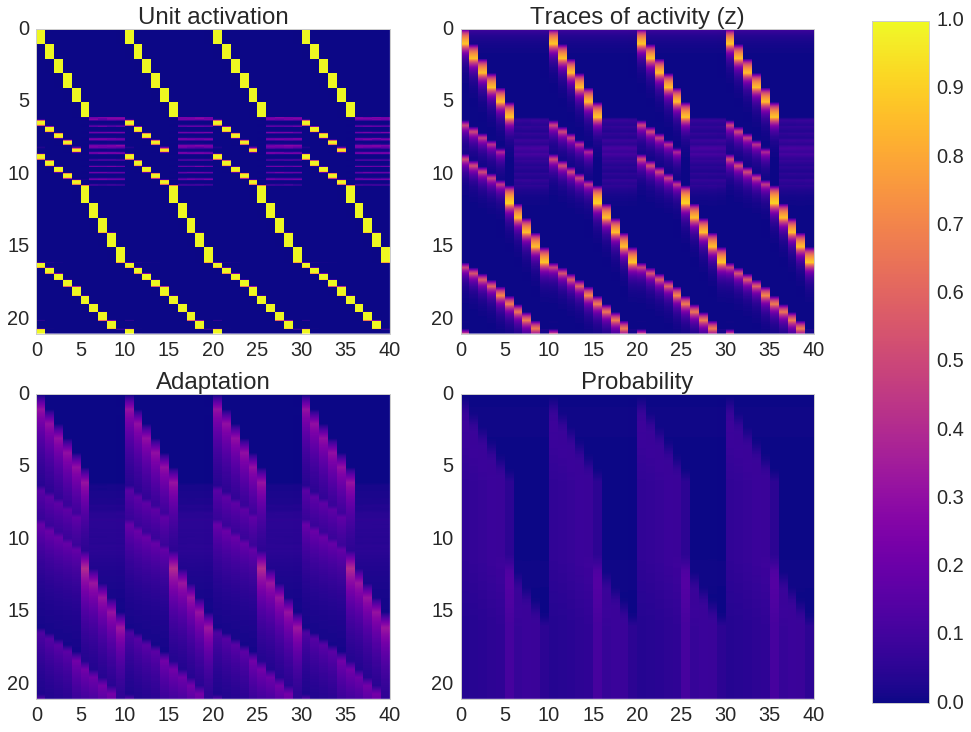

In [7]:
plot_network_activity(manager)

NMDA connnections

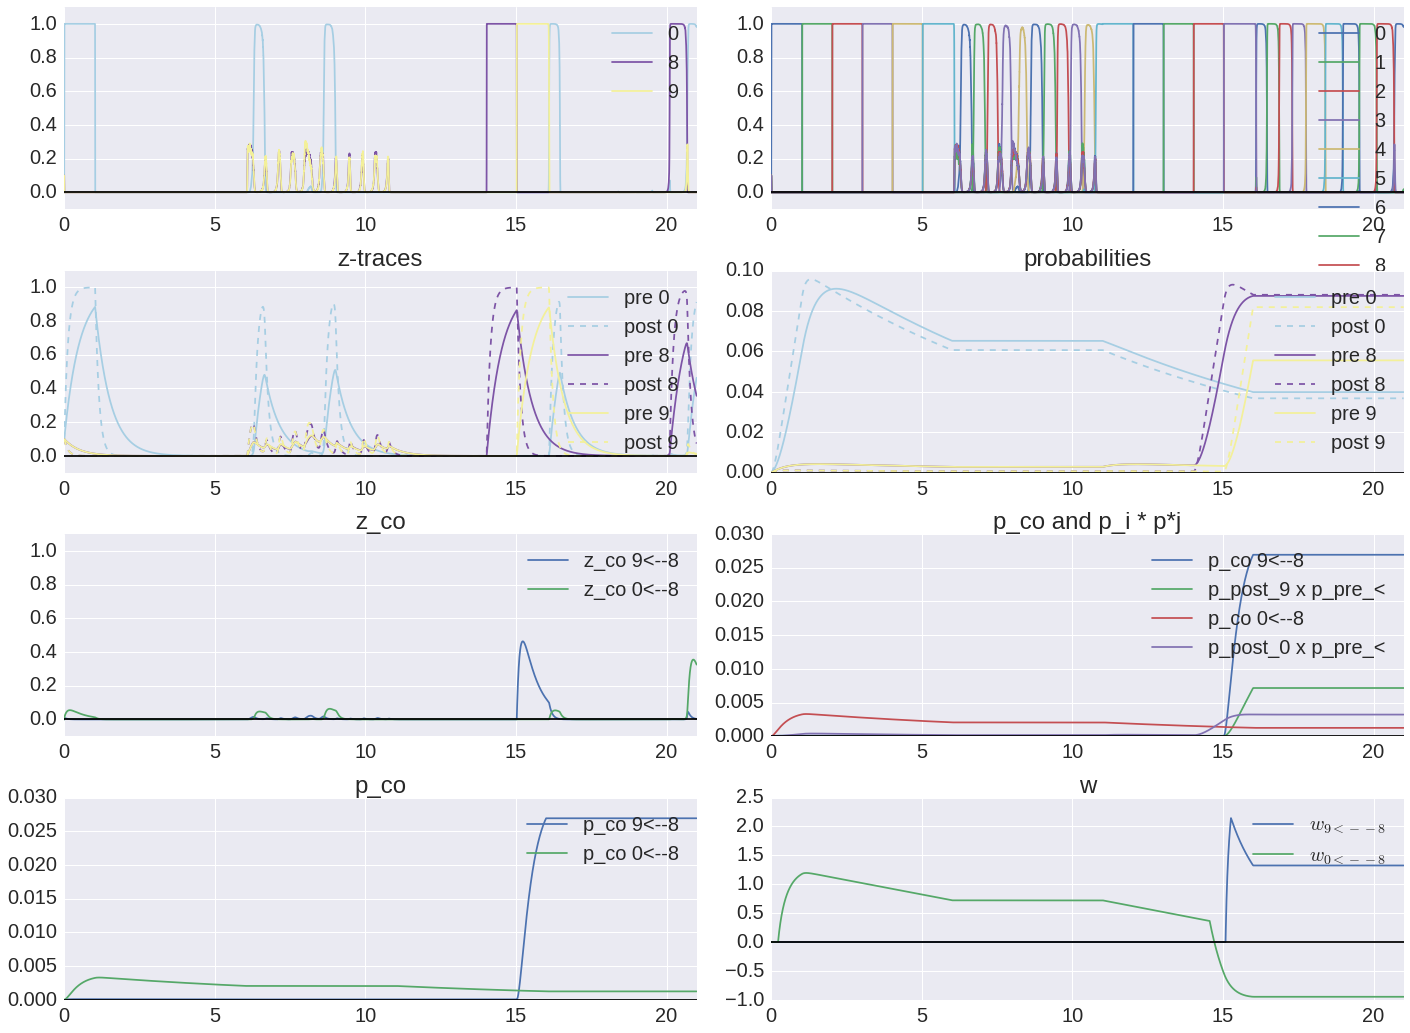

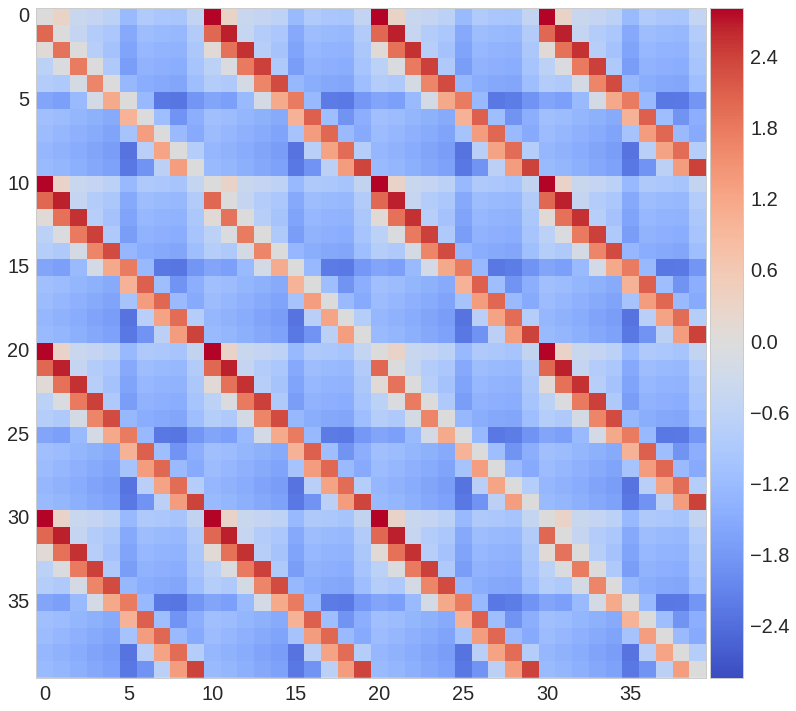

In [8]:
traces_to_plot = [0, 8, 9]
plot_state_variables_vs_time(manager, traces_to_plot, ampa=False)
plot_weight_matrix(nn, ampa=False)

AMPA connections

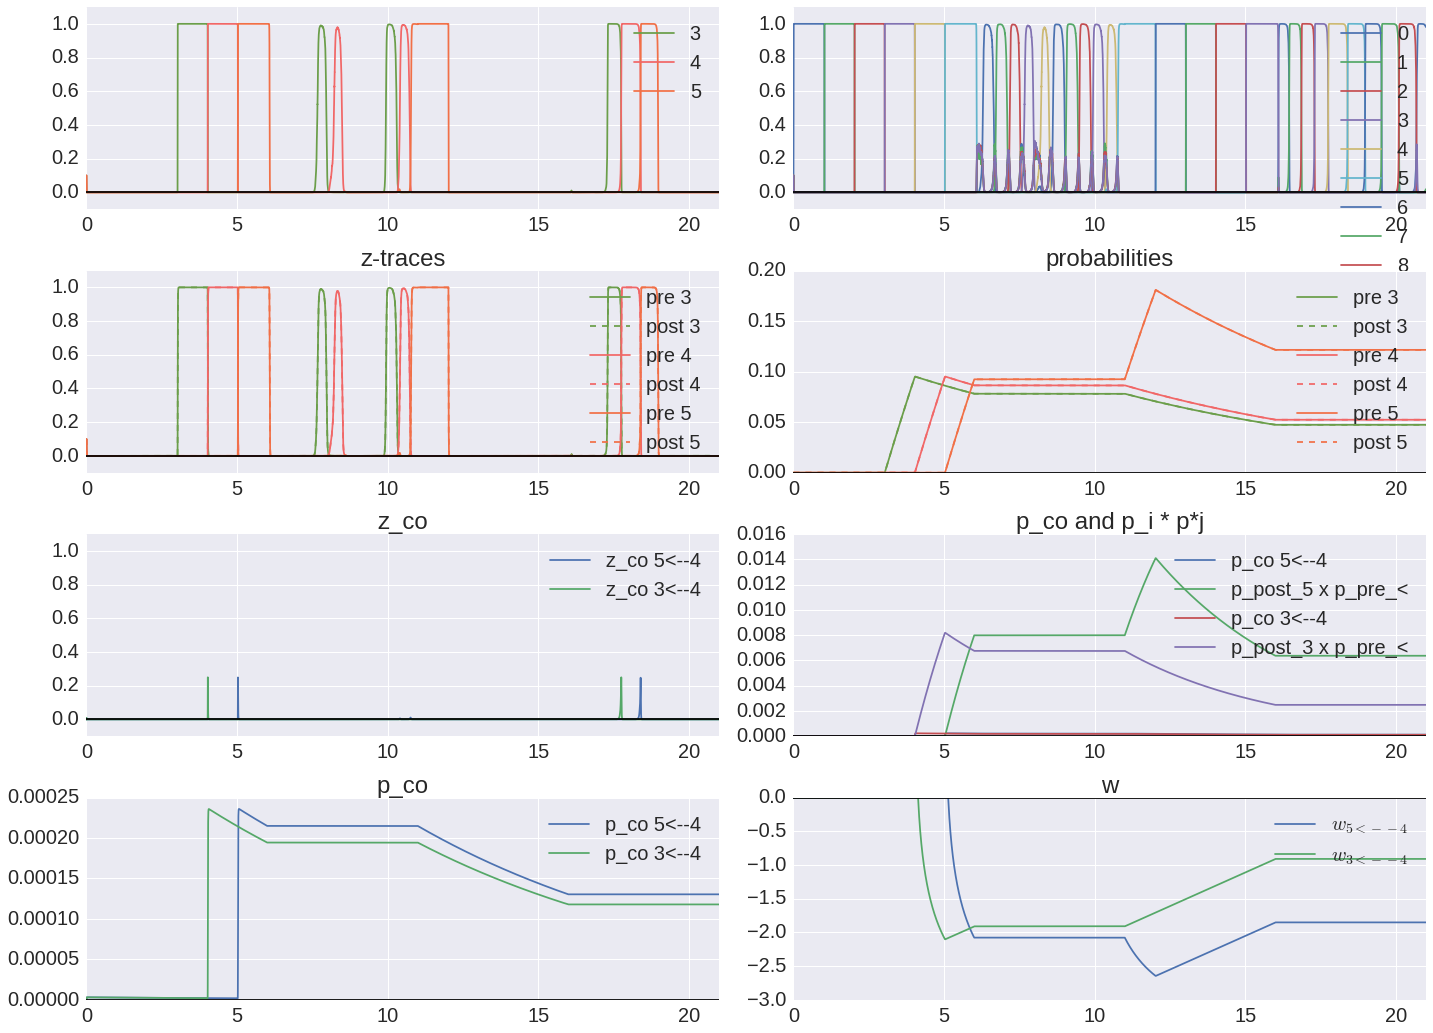

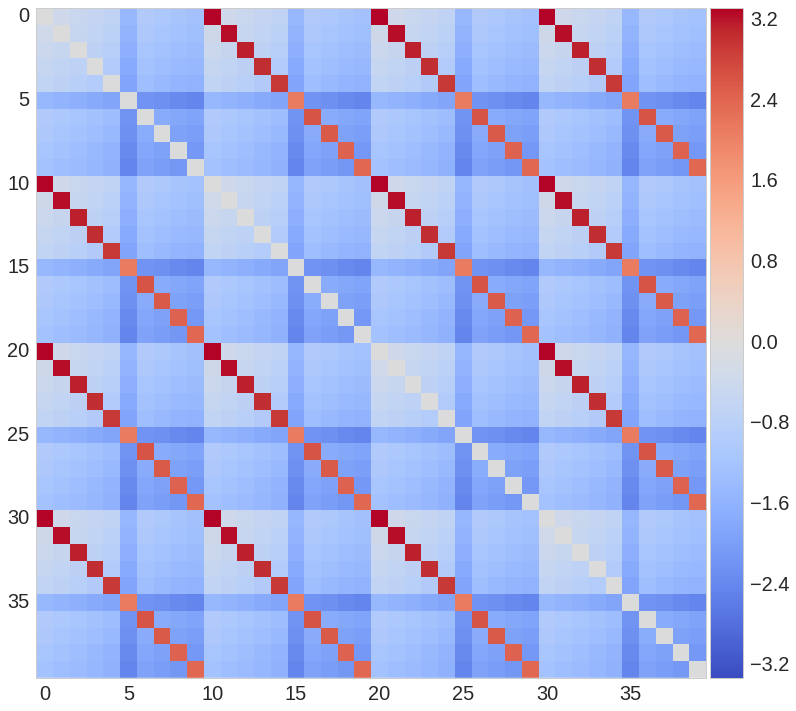

In [9]:
traces_to_plot = [3, 4, 5]
plot_state_variables_vs_time(manager, traces_to_plot, ampa=True)
plot_weight_matrix(nn, ampa=True)

#### Recalling

AMPA connections only

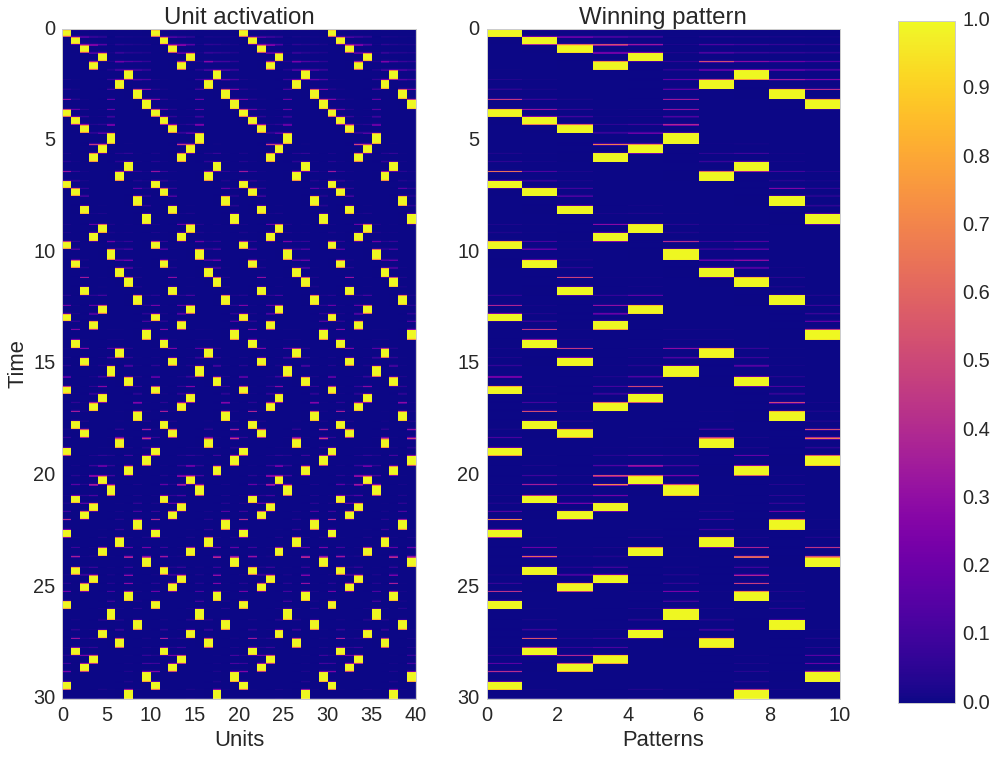

In [10]:
manager.nn.g_w_ampa = 1.0
manager.nn.g_w = 0.0
manager.update_saving_dictionary(['o'])
manager.patterns = patterns
manager.run_network_recall()
plot_network_activity_angle(manager)

Both AMPA and NMDA connections

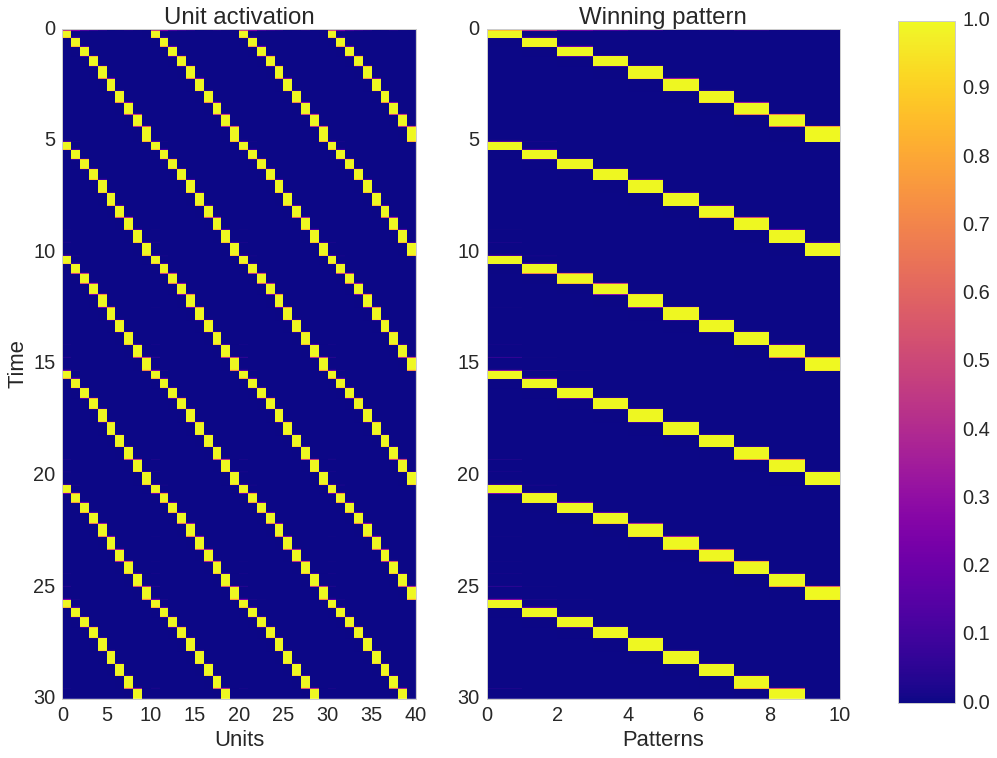

In [11]:
manager.nn.g_w_ampa = 1.0
manager.nn.g_w = 1.0
manager.update_saving_dictionary(['o'])
manager.run_network_recall()
plot_network_activity_angle(manager)

Now we start cuing a particular pattern to see if the network progresses

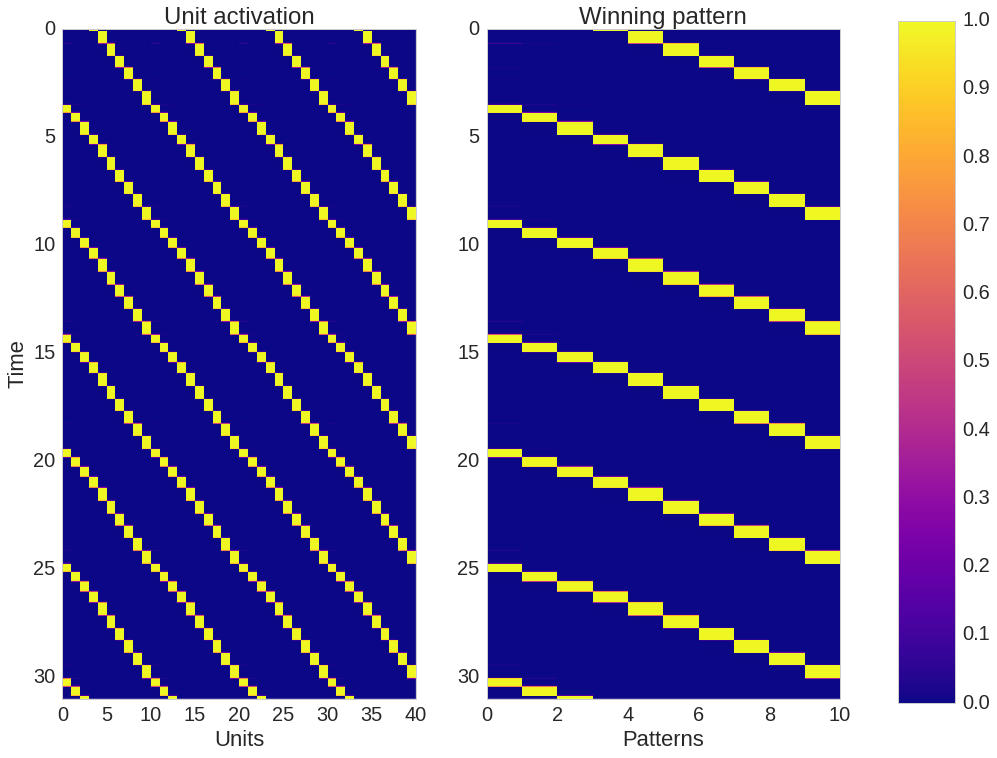

In [12]:
nn.reset_values(keep_connectivity=True)
manager.run_network(time=manager.time_training, I=patterns[3])
manager.run_network_recall(reset=False)
manager.T_total = T_recalling + T_training
plot_network_activity_angle(manager)

#### Git reload

In [13]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])